# 通し課題　DAY2
Theme : Car consume

■分析のシナリオ

１．必要なライブラリーの読み込み  

２．csvデータの読み込みと確認  

３．前処理(NEW)  
         ・欠損値補完  
         ・質的データの整理とダミーデータ化  
         ・量的データの標準化  
         ・外れ値の確認と削除  
         
４．回帰分析によりconsumeを予測してみる  
         ・ホールドアウト法  
         ・クロスバリデーション法  

５．分類問題
　　ロジスティック回帰、線形SVM、非線形SVMの3種で、consumeが平均値以上か以下かを予測してみる





# データの説明

■量的データ  
distance : 走行距離(km)  
consume : 目的変数燃費(L/100km)  
speed : 平均走行時速(km/h)  
temp_inside :　車室内温度(℃)  
temp_outside : 車室外温度(℃)  
refill liters : 再給油量(L)   


■質的データ  
specials: 特別な出来事の記述  
gas_type: E10 or SP98  
rain: 雨が降ったか  
sun: 乗車時暑いと感じたとき  
refill gas: 再給油のガス種類　(※gas_typeの情報を引き継いでいるので今回使用しない)  


# 参考URL
前処理がわかりやすかった。　http://sinhrks.hatenablog.com/entry/2016/02/01/080859

In [37]:
###　１．必要なライブラリーの読み込み）################################

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.svm import SVC

from mpl_toolkits.mplot3d import Axes3D
import scipy.stats
import datetime


# from matplotlib.font_manager import FontProperties
# fp = FontProperties(fname=r'C:\WINDOWS\Fonts\YuGothic.ttf', size=14)

In [3]:
### ２．データの読込みと確認）################################


# csvデータの読込み
df = pd.read_csv('measurements.csv')


# データの確認
print(df.dtypes)
display(df.head())
df.describe()


distance         object
consume          object
speed             int64
temp_inside      object
temp_outside      int64
specials         object
gas_type         object
AC                int64
rain              int64
sun               int64
refill_liters    object
refill_gas       object
dtype: object


,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill_liters,refill_gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN


,speed,temp_outside,AC,rain,sun
count,388.000000,388.000000,388.000000,388.000000,388.000000
mean,41.927835,11.358247,0.077320,0.123711,0.082474
std,13.598524,6.991542,0.267443,0.329677,0.275441
min,14.000000,-5.000000,0.000000,0.000000,0.000000
25%,32.750000,7.000000,0.000000,0.000000,0.000000
50%,40.500000,10.000000,0.000000,0.000000,0.000000
75%,50.000000,16.000000,0.000000,0.000000,0.000000
max,90.000000,31.000000,1.000000,1.000000,1.000000


In [4]:
## データ型の変換

# object型になっている量的データをfloat型に変換し,を.に修正
df.distance = df.distance.str.replace(',', '.').astype(float)
df.consume = df.consume.str.replace(',', '.').astype(float)
df.temp_inside = df.temp_inside.str.replace(',', '.').astype(float)
df.refill_liters = df.refill_liters.str.replace(',', '.').astype(float)

# 欠損値NaNの確認
print(df.isnull().any(axis=0))

# データの確認
display(df.head())
df.describe()

distance         False
consume          False
speed            False
temp_inside       True
temp_outside     False
specials          True
gas_type         False
AC               False
rain             False
sun              False
refill_liters     True
refill_gas        True
dtype: bool


,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill_liters,refill_gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN


,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill_liters
count,388.000000,388.000000,388.000000,376.000000,388.000000,388.000000,388.000000,388.000000,13.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.077320,0.123711,0.082474,37.115385
std,22.667837,1.033172,13.598524,1.010455,6.991542,0.267443,0.329677,0.275441,8.587282
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,10.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,37.600000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,0.000000,0.000000,0.000000,38.000000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,0.000000,0.000000,0.000000,39.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,45.000000


In [5]:
###　前処理（NEW）################################

##　欠損値の補完

# 欠損値の補完
df.refill_liters = df.refill_liters.fillna(0)                             # reill_litersがNaNの場合、再給油なしと解釈しNaN=0とした
df.temp_inside = df.temp_inside.fillna(np.nanmean(df.temp_inside))        # temp_insideがNaNの場合、temp_insideの平均値を代入
df.specials = df.specials.fillna('nothing')                               # specialsがNaNのとき、nothing標記に変更
df = df.drop("refill_gas", axis=1)                                        # refill_gasはgas_typeを引き継いでいるため削除

# 欠損値NaNの確認
print(df.isnull().any(axis=0))

# データの確認
display(df.head())
df.describe()

distance         False
consume          False
speed            False
temp_inside      False
temp_outside     False
specials         False
gas_type         False
AC               False
rain             False
sun              False
refill_liters    False
dtype: bool


,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill_liters
0,28.0,5.0,26,21.5,12,nothing,E10,0,0,0,45.0
1,12.0,4.2,30,21.5,13,nothing,E10,0,0,0,0.0
2,11.2,5.5,38,21.5,15,nothing,E10,0,0,0,0.0
3,12.9,3.9,36,21.5,14,nothing,E10,0,0,0,0.0
4,18.5,4.5,46,21.5,15,nothing,E10,0,0,0,0.0


,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill_liters
count,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.077320,0.123711,0.082474,1.243557
std,22.667837,1.033172,13.598524,0.994666,6.991542,0.267443,0.329677,0.275441,6.856419
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,0.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,0.000000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,0.000000,0.000000,0.000000,0.000000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,0.000000,0.000000,0.000000,0.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,45.000000


Text(0, 0.5, 'degree')

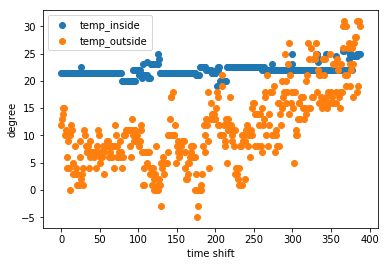

In [6]:
## temp_insideの欠損値補完について

#　時系列データとしてみた場合、季節変動などがあるので、欠損値近傍での平均化の方がベターか？
#　まずは、可視化で傾向を捉える

plt.scatter(np.arange(0,len(df['temp_inside'])), df['temp_inside'], label='temp_inside')          # 車室内
plt.scatter(np.arange(0,len(df['temp_outside'])), df['temp_outside'], label='temp_outside')       # 車室外
plt.legend()
plt.xlabel('time shift')
plt.ylabel('degree')

コメント：  
１．車室外の気温に比べ、車室内の気温は振れ幅が少なく安定しているため、欠損値の補完は全体平均値で問題ないとした。  
２．車室外の気温は右上がりな傾向(冬⇒春)が見られ、temp_outsideを補完する場合は時系列性を考慮すべきだと感じる。  

In [7]:
# ##　変数の追加
# # 車室内と外の温度差によりACを使用したり、エンジンの熱変換などの燃費性能が変化することが考えられる。
# # まずは可視化してみる。

# #　車室内外気温差変数
# temp_inout = []
# temp_inout = df['temp_inside'] - df['temp_outside']


# # 気温差と燃費の回帰分析も一応行ってみる
# y = df["consume"].values  #目的変数
# x = temp_inout.values     #説明変数
# X = x.reshape(-1,1)

# regr = LinearRegression(fit_intercept=True)
# regr.fit(X, y)
# y_est_sklearn = regr.intercept_ + regr.coef_[0] * x


# # グラフ表示
# plt.plot(temp_inout, df['consume'], 'o')  
# plt.legend()
# plt.xlabel('temp_inout')
# plt.ylabel('consume')
# plt.plot(x, y_est_sklearn)
# plt.show()


# # データフレームに新変数を格納し確認
# df['temp_inout'] = temp_inout
# display(df.head())
# df.describe()

コメント：  
車室内外の気温差を新変数として追加しようとしたが、車室外の気温と非常に相関が高く(車室内音がほぼコンスタントな値を取っているため、車室外の相対的な値の変化に留まってしまう)使うのをやめた。

In [8]:
## 質的データの整理とダミーデータ化

# specialsの文字列整理（大文字と小文字,単語順序）
df.specials = df.specials.str.lower()
df.specials = df.specials.replace("sun ac", "ac sun")


# 質的データの中身確認
print('specialの中身：' + str(df.specials.unique()))  
print('gas typeの中身：' + str(df.gas_type.unique()))  
print('ACの中身：' + str(df.AC.unique())) 
print('rainの中身：' + str(df.rain.unique()))  
print('sunの中身：' + str(df.sun.unique()))    


# 質的データを量的データ(ダミーデータ)に変換
# E10 = 0, SP98 = 1
df.loc[df['gas_type'] == 'E10', 'gas_type'] = 0
df.loc[df['gas_type'] == 'SP98', 'gas_type'] = 1


# specialsの中のデータをonehotに変換
df = pd.get_dummies(df)                               # objectかカテゴリデータのみがonehot化される


# データ確認
display(df.head())
df.describe()



specialの中身：['nothing' 'ac rain' 'ac' 'rain' 'snow' 'ac snow' 'half rain half sun'
 'sun' 'ac sun']
gas typeの中身：['E10' 'SP98']
ACの中身：[0 1]
rainの中身：[0 1]
sunの中身：[0 1]


,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,refill_liters,specials_ac,specials_ac rain,specials_ac snow,specials_ac sun,specials_half rain half sun,specials_nothing,specials_rain,specials_snow,specials_sun
0,28.0,5.0,26,21.5,12,0,0,0,0,45.0,0,0,0,0,0,1,0,0,0
1,12.0,4.2,30,21.5,13,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0
2,11.2,5.5,38,21.5,15,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0
3,12.9,3.9,36,21.5,14,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0
4,18.5,4.5,46,21.5,15,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0


,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,refill_liters,specials_ac,specials_ac rain,specials_ac snow,specials_ac sun,specials_half rain half sun,specials_nothing,specials_rain,specials_snow,specials_sun
count,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.587629,0.077320,0.123711,0.082474,1.243557,0.036082,0.025773,0.002577,0.012887,0.002577,0.760309,0.082474,0.007732,0.069588
std,22.667837,1.033172,13.598524,0.994666,6.991542,0.492897,0.267443,0.329677,0.275441,6.856419,0.186736,0.158663,0.050767,0.112931,0.050767,0.427446,0.275441,0.087704,0.254779
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,1.000000,45.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
#　specialsの組み合わせを使うか、AC, rain, sunのもともとの変数を使うかで迷ったため、dfを2バージョン作成し精度を比較できるようにしておく。
#　df1はAC, rain, sun、　df2はspecialsをonehot化したもの

df1 = df[["distance", "consume", "speed", "temp_inside", "temp_outside", "gas_type", "AC", "rain", "sun", "refill_liters"]]
df2 = df.drop(columns=["AC", "rain", "sun"], axis=1)

# データ確認
display(df1.head())
display(df2.head())

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,refill_liters
0,28.0,5.0,26,21.5,12,0,0,0,0,45.0
1,12.0,4.2,30,21.5,13,0,0,0,0,0.0
2,11.2,5.5,38,21.5,15,0,0,0,0,0.0
3,12.9,3.9,36,21.5,14,0,0,0,0,0.0
4,18.5,4.5,46,21.5,15,0,0,0,0,0.0


,distance,consume,speed,temp_inside,temp_outside,gas_type,refill_liters,specials_ac,specials_ac rain,specials_ac snow,specials_ac sun,specials_half rain half sun,specials_nothing,specials_rain,specials_snow,specials_sun
0,28.0,5.0,26,21.5,12,0,45.0,0,0,0,0,0,1,0,0,0
1,12.0,4.2,30,21.5,13,0,0.0,0,0,0,0,0,1,0,0,0
2,11.2,5.5,38,21.5,15,0,0.0,0,0,0,0,0,1,0,0,0
3,12.9,3.9,36,21.5,14,0,0.0,0,0,0,0,0,1,0,0,0
4,18.5,4.5,46,21.5,15,0,0.0,0,0,0,0,0,1,0,0,0


コメント：  
specialsをonehot化したものは(snowも含む)各組合せ分あるため項目数は増える。

In [10]:
##　量的データの標準化
# scipyによる標準化

df1_norm = df1
df2_norm = df2
# df1_norm.loc[:,['distance','consume','speed','temp_inside','temp_outside','refill_liters','temp_inout']] = scipy.stats.zscore(df1_norm.loc[:,['distance','consume','speed','temp_inside','temp_outside','refill_liters','temp_inout']])
# df2_norm.loc[:,['distance','consume','speed','temp_inside','temp_outside','refill_liters','temp_inout']] = scipy.stats.zscore(df1_norm.loc[:,['distance','consume','speed','temp_inside','temp_outside','refill_liters','temp_inout']])
df1_norm.loc[:,['distance','consume','speed','temp_inside','temp_outside','refill_liters']] = scipy.stats.zscore(df1.loc[:,['distance','consume','speed','temp_inside','temp_outside','refill_liters']])
df2_norm.loc[:,['distance','consume','speed','temp_inside','temp_outside','refill_liters']] = scipy.stats.zscore(df1.loc[:,['distance','consume','speed','temp_inside','temp_outside','refill_liters']])



# データ確認
display(df2_norm.head())
df2_norm.describe()

display(df2.head())
df2.describe()

C:\Users\QD457275\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,distance,consume,speed,temp_inside,temp_outside,gas_type,refill_liters,specials_ac,specials_ac rain,specials_ac snow,specials_ac sun,specials_half rain half sun,specials_nothing,specials_rain,specials_snow,specials_sun
0,0.368714,0.084925,-1.172804,-0.432382,0.091908,0,6.390062,0,0,0,0,0,1,0,0,0
1,-0.338044,-0.690390,-0.878274,-0.432382,0.235123,0,-0.181605,0,0,0,0,0,1,0,0,0
2,-0.373381,0.569497,-0.289216,-0.432382,0.521552,0,-0.181605,0,0,0,0,0,1,0,0,0
3,-0.298288,-0.981133,-0.436480,-0.432382,0.378338,0,-0.181605,0,0,0,0,0,1,0,0,0
4,-0.050923,-0.399647,0.299843,-0.432382,0.521552,0,-0.181605,0,0,0,0,0,1,0,0,0


,distance,consume,speed,temp_inside,temp_outside,gas_type,refill_liters,specials_ac,specials_ac rain,specials_ac snow,specials_ac sun,specials_half rain half sun,specials_nothing,specials_rain,specials_snow,specials_sun
0,0.368714,0.084925,-1.172804,-0.432382,0.091908,0,6.390062,0,0,0,0,0,1,0,0,0
1,-0.338044,-0.690390,-0.878274,-0.432382,0.235123,0,-0.181605,0,0,0,0,0,1,0,0,0
2,-0.373381,0.569497,-0.289216,-0.432382,0.521552,0,-0.181605,0,0,0,0,0,1,0,0,0
3,-0.298288,-0.981133,-0.436480,-0.432382,0.378338,0,-0.181605,0,0,0,0,0,1,0,0,0
4,-0.050923,-0.399647,0.299843,-0.432382,0.521552,0,-0.181605,0,0,0,0,0,1,0,0,0


,distance,consume,speed,temp_inside,temp_outside,gas_type,refill_liters,specials_ac,specials_ac rain,specials_ac snow,specials_ac sun,specials_half rain half sun,specials_nothing,specials_rain,specials_snow,specials_sun
count,3.880000e+02,3.880000e+02,3.880000e+02,3.880000e+02,3.880000e+02,388.000000,3.880000e+02,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000
mean,1.538002e-17,-5.046793e-17,4.807151e-17,-2.424178e-15,4.475229e-16,0.587629,1.545156e-17,0.036082,0.025773,0.002577,0.012887,0.002577,0.760309,0.082474,0.007732,0.069588
std,1.001291e+00,1.001291e+00,1.001291e+00,1.001291e+00,1.001291e+00,0.492897,1.001291e+00,0.186736,0.158663,0.050767,0.112931,0.050767,0.427446,0.275441,0.087704,0.254779
min,-8.106875e-01,-1.562618e+00,-2.056392e+00,-2.949035e+00,-2.342740e+00,0.000000,-1.816054e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-3.468780e-01,-5.934753e-01,-6.757855e-01,-4.323823e-01,-6.241648e-01,0.000000,-1.816054e-01,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,-2.231955e-01,-2.058180e-01,-1.051348e-01,7.094818e-02,-1.945209e-01,1.000000,-1.816054e-01,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,-2.883725e-02,3.756679e-01,5.943724e-01,5.742786e-01,6.647669e-01,1.000000,-1.816054e-01,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,8.677529e+00,7.062756e+00,3.539666e+00,3.594261e+00,2.812986e+00,1.000000,6.390062e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


コメント：  
量的データの平均値がゼロで分散１になっていることを確認。
ここで、Warningがでるが、df1とdf2のデータも正規化されてしまっている。対処法が分からない・・・

<Figure size 1152x1152 with 0 Axes>

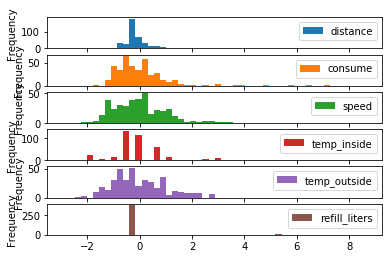

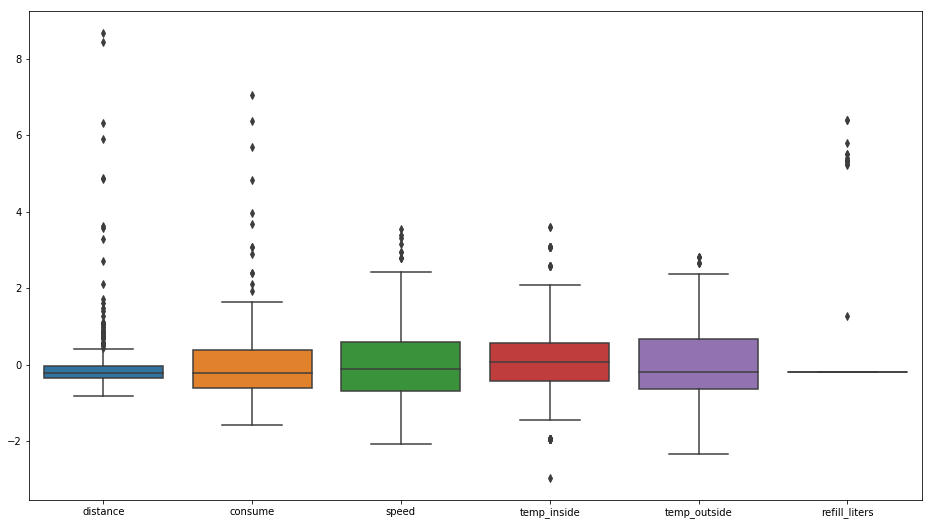

In [11]:
## 外れ値の確認
# ヒストグラムとIQRを使って外れ値を確認する（量的データに適用）

df_norm_num = df1_norm[["distance", "consume", "speed", "temp_inside", "temp_outside", "refill_liters"]]

plt.figure(figsize=(16,16))
df_norm_num.plot(kind='hist', bins=50, subplots=True);
plt.show()

plt.figure(figsize=(16,9))
sns.boxplot(data=df_norm_num)
plt.show()


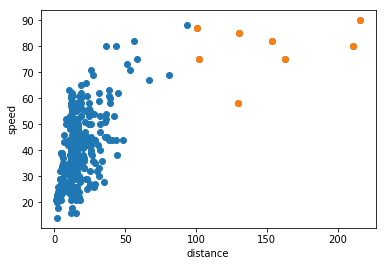

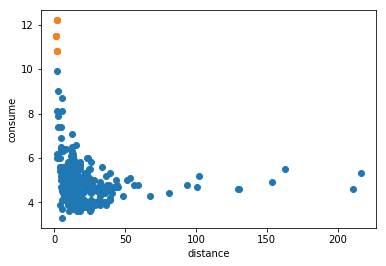

Text(0.5, 1.0, 'remove outlier')

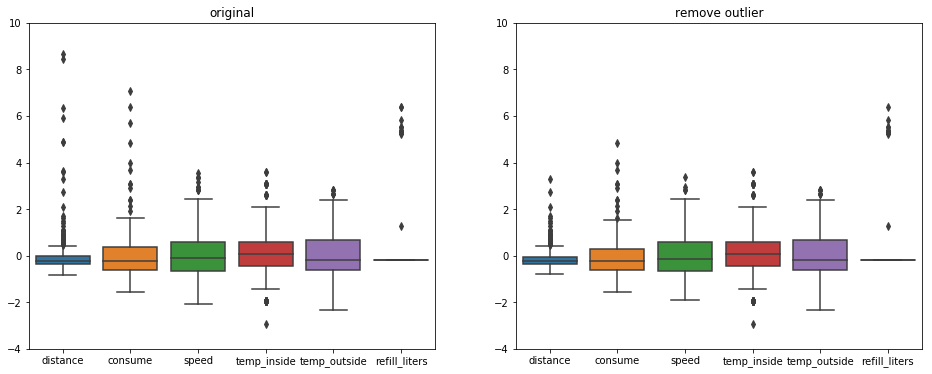

In [12]:
##　外れ値を定義し除外
#　１．distanceで外れ値の割合が高い。走行距離が長いロングトリップ(100km以上、平均値は20km)ものを排除　
#　⇒　distance長いとspeedの外れ値も取り除ける可能性大。
plt.plot(df['distance'].values, df['speed'].values, 'o')
temp1 = df.query('distance>100')
plt.plot(temp1['distance'].values, temp1['speed'].values, 'o')
plt.xlabel('distance')
plt.ylabel('speed')
plt.show()

#　２．consumeの値が大きすぎるものがある。10>L/100kmのものを排除(平均5L/100km)　
#　⇒　傾向としては走行距離がかなり少ないとき(2kmぐらい)
plt.plot(df['distance'].values, df['consume'].values, 'o')
temp2 = df.query('consume>10')
plt.plot(temp2['distance'].values, temp2['consume'].values, 'o')
plt.xlabel('distance')
plt.ylabel('consume')
plt.show()

#　外れ値を除外後IQRを表示
ind_dis = (100-df['distance'].mean())/np.std(df['distance'])
df_norm_num_iqr = (df_norm_num[df_norm_num['distance'] < ind_dis])
ind_con = (10-df['consume'].mean())/np.std(df['consume'])
df_norm_num_iqr = (df_norm_num_iqr[df_norm_num_iqr['consume'] < ind_con])
#df_norm_num_iqr = df_norm_num.query('distance > ind_dis')


plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.ylim([-4,10])
plt.title("original")
sns.boxplot(data=df_norm_num)
plt.subplot(1,2,2)
plt.ylim([-4,10])
sns.boxplot(data=df_norm_num_iqr)
plt.title("remove outlier")
# plt.title("外れ値除外後", fontproperties=fp)



コメント：  
ボックスプロットの可視化で、外れ値削除後の方が、データのまとまりがみられる。外れ値の閾値をどのくらいに設定するかは難しいところ。後に、外れ値考慮ありなしで、予測精度を比較してみたい。

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,refill_liters
0,0.368714,0.084925,-1.172804,-0.432382,0.091908,0,0,0,0,6.390062
1,-0.338044,-0.690390,-0.878274,-0.432382,0.235123,0,0,0,0,-0.181605
2,-0.373381,0.569497,-0.289216,-0.432382,0.521552,0,0,0,0,-0.181605
3,-0.298288,-0.981133,-0.436480,-0.432382,0.378338,0,0,0,0,-0.181605
4,-0.050923,-0.399647,0.299843,-0.432382,0.521552,0,0,0,0,-0.181605


,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,refill_liters
0,1.017449,0.162829,-1.233619,-0.428419,0.100479,0,0,0,0,6.675309
1,-0.464299,-0.765511,-0.911545,-0.428419,0.243966,0,0,0,0,-0.176702
2,-0.538386,0.743041,-0.267398,-0.428419,0.530941,0,0,0,0,-0.176702
3,-0.380951,-1.113639,-0.428435,-0.428419,0.387453,0,0,0,0,-0.176702
4,0.137661,-0.417384,0.376749,-0.428419,0.530941,0,0,0,0,-0.176702


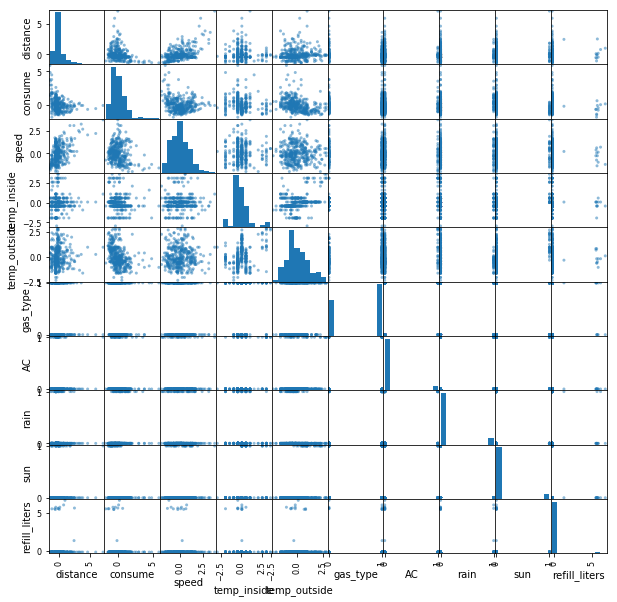

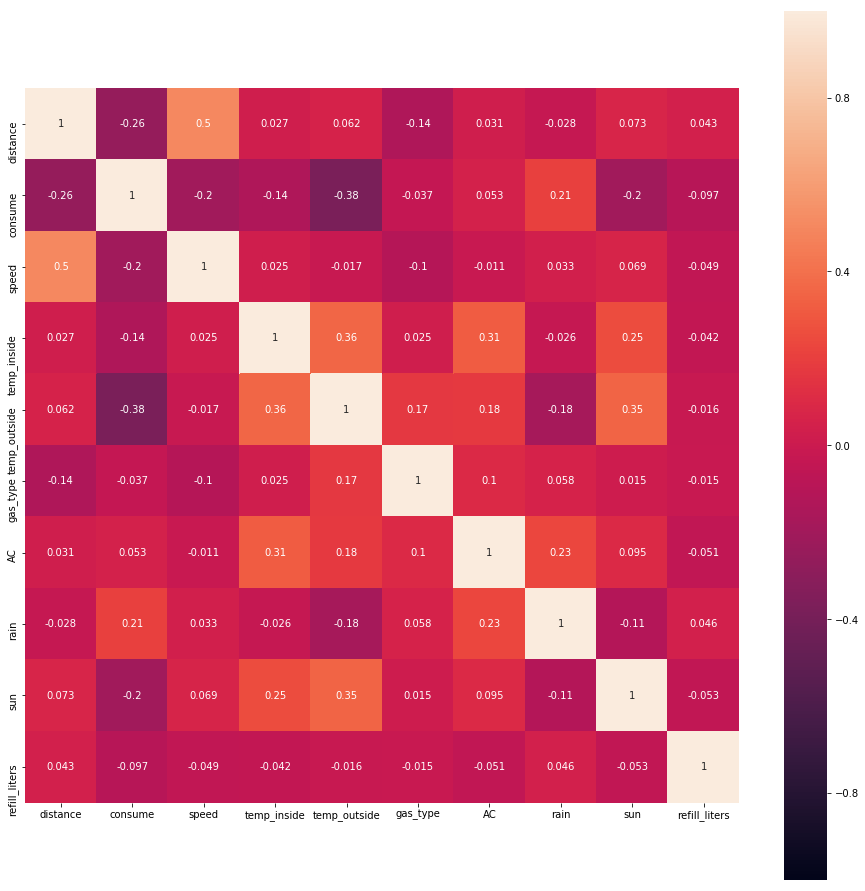

In [13]:
## 前処理実施後のデータ確認

ind_dis = (100-df['distance'].mean())/np.std(df['distance'])
df1_norm_iqr = (df1_norm[df1_norm['distance'] < ind_dis])
ind_con = (10-df['consume'].mean())/np.std(df['consume'])
df1_norm_iqr = (df1_norm_iqr[df1_norm_iqr['consume'] < ind_con])

ind_dis = (100-df['distance'].mean())/np.std(df['distance'])
df2_norm_iqr = (df2_norm[df2_norm['distance'] < ind_dis])
ind_con = (10-df['consume'].mean())/np.std(df['consume'])
df2_norm_iqr = (df2_norm_iqr[df2_norm_iqr['consume'] < ind_con])

# 外れ値抜いた分、再度標準化
df1_norm_iqr.loc[:,['distance','consume','speed','temp_inside','temp_outside','refill_liters']] = scipy.stats.zscore(df1_norm_iqr.loc[:,['distance','consume','speed','temp_inside','temp_outside','refill_liters']])
df2_norm_iqr.loc[:,['distance','consume','speed','temp_inside','temp_outside','refill_liters']] = scipy.stats.zscore(df2_norm_iqr.loc[:,['distance','consume','speed','temp_inside','temp_outside','refill_liters']])


# データ確認
display(df1_norm.head())
df1_norm_iqr.describe()

display(df1_norm_iqr.head())
df2_norm_iqr.describe()


# 散布図
pd.plotting.scatter_matrix(df1_norm_iqr, figsize=(10,10))
plt.show()

# 相関マトリクスヒートマップ
plt.figure(figsize=(16,16))
heatmap = sns.heatmap(df1_norm_iqr.corr(), cbar=True, annot=True, square=True,
                      vmin=-1.0, vmax=1.0)


In [14]:
## consumeは標準化からリアルな値へ戻しておく
df1_norm.loc[:,['consume']] = df['consume']
df2_norm.loc[:,['consume']] = df['consume']
df1_norm_iqr.loc[:,['consume']] = df['consume']
df2_norm_iqr.loc[:,['consume']] = df['consume']


##　最終データの確認
display(df1_norm.head())
display(df1_norm_iqr.head())
display(df2_norm.head())
display(df2_norm_iqr.head())
df1_norm.describe()

C:\Users\QD457275\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,refill_liters
0,0.368714,5.0,-1.172804,-0.432382,0.091908,0,0,0,0,6.390062
1,-0.338044,4.2,-0.878274,-0.432382,0.235123,0,0,0,0,-0.181605
2,-0.373381,5.5,-0.289216,-0.432382,0.521552,0,0,0,0,-0.181605
3,-0.298288,3.9,-0.436480,-0.432382,0.378338,0,0,0,0,-0.181605
4,-0.050923,4.5,0.299843,-0.432382,0.521552,0,0,0,0,-0.181605


,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,refill_liters
0,1.017449,5.0,-1.233619,-0.428419,0.100479,0,0,0,0,6.675309
1,-0.464299,4.2,-0.911545,-0.428419,0.243966,0,0,0,0,-0.176702
2,-0.538386,5.5,-0.267398,-0.428419,0.530941,0,0,0,0,-0.176702
3,-0.380951,3.9,-0.428435,-0.428419,0.387453,0,0,0,0,-0.176702
4,0.137661,4.5,0.376749,-0.428419,0.530941,0,0,0,0,-0.176702


,distance,consume,speed,temp_inside,temp_outside,gas_type,refill_liters,specials_ac,specials_ac rain,specials_ac snow,specials_ac sun,specials_half rain half sun,specials_nothing,specials_rain,specials_snow,specials_sun
0,0.368714,5.0,-1.172804,-0.432382,0.091908,0,6.390062,0,0,0,0,0,1,0,0,0
1,-0.338044,4.2,-0.878274,-0.432382,0.235123,0,-0.181605,0,0,0,0,0,1,0,0,0
2,-0.373381,5.5,-0.289216,-0.432382,0.521552,0,-0.181605,0,0,0,0,0,1,0,0,0
3,-0.298288,3.9,-0.436480,-0.432382,0.378338,0,-0.181605,0,0,0,0,0,1,0,0,0
4,-0.050923,4.5,0.299843,-0.432382,0.521552,0,-0.181605,0,0,0,0,0,1,0,0,0


,distance,consume,speed,temp_inside,temp_outside,gas_type,refill_liters,specials_ac,specials_ac rain,specials_ac snow,specials_ac sun,specials_half rain half sun,specials_nothing,specials_rain,specials_snow,specials_sun
0,1.017449,5.0,-1.233619,-0.428419,0.100479,0,6.675309,0,0,0,0,0,1,0,0,0
1,-0.464299,4.2,-0.911545,-0.428419,0.243966,0,-0.176702,0,0,0,0,0,1,0,0,0
2,-0.538386,5.5,-0.267398,-0.428419,0.530941,0,-0.176702,0,0,0,0,0,1,0,0,0
3,-0.380951,3.9,-0.428435,-0.428419,0.387453,0,-0.176702,0,0,0,0,0,1,0,0,0
4,0.137661,4.5,0.376749,-0.428419,0.530941,0,-0.176702,0,0,0,0,0,1,0,0,0


,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun,refill_liters
count,3.880000e+02,388.000000,3.880000e+02,3.880000e+02,3.880000e+02,388.000000,388.000000,388.000000,388.000000,3.880000e+02
mean,1.322682e-16,4.912371,2.392130e-16,-3.834275e-15,4.475229e-16,0.587629,0.077320,0.123711,0.082474,-1.445007e-17
std,1.001291e+00,1.033172,1.001291e+00,1.001291e+00,1.001291e+00,0.492897,0.267443,0.329677,0.275441,1.001291e+00
min,-8.106875e-01,3.300000,-2.056392e+00,-2.949035e+00,-2.342740e+00,0.000000,0.000000,0.000000,0.000000,-1.816054e-01
25%,-3.468780e-01,4.300000,-6.757855e-01,-4.323823e-01,-6.241648e-01,0.000000,0.000000,0.000000,0.000000,-1.816054e-01
50%,-2.231955e-01,4.700000,-1.051348e-01,7.094818e-02,-1.945209e-01,1.000000,0.000000,0.000000,0.000000,-1.816054e-01
75%,-2.883725e-02,5.300000,5.943724e-01,5.742786e-01,6.647669e-01,1.000000,0.000000,0.000000,0.000000,-1.816054e-01
max,8.677529e+00,12.200000,3.539666e+00,3.594261e+00,2.812986e+00,1.000000,1.000000,1.000000,1.000000,6.390062e+00


# データフレームの整理
・df1　⇒　specialsの代わりにAC、rain、sunを使用  
・df2　⇒　specialsをonehot化し、AC、rain、sunを排除  
※なぜか、df1,df2も正規化された状態になっている。原因不明・・・  
・df1_norm, df2_norm　⇒　df1,df2の量的データを標準化  
・df1_norm_iqr, df2_norm_iqr　⇒　df1,df2の量的データを標準化し、さらに外れ値を定義して排除


# 予測モデルの構築　
 
 １．回帰分析：  
 　　目的変数：consume  
 ２．ロジスティック回帰：  
 　　目的変数：consume(平均値以上かどうかを判定)  

In [15]:
###　１．線形回帰分析 df1_norm v.s. df2_normの精度を比較

##　全データを使用して精度を比較
# 係数を求める
y1 = df1_norm["consume"].values                                              #目的変数
X1 = df1_norm.drop("consume", axis=1).values     #説明変数
regr1 = LinearRegression(fit_intercept=True)
regr1.fit(X1, y1)

y2 = df2_norm["consume"].values                                              #目的変数
X2 = df2_norm.drop("consume", axis=1).values     #説明変数
regr2 = LinearRegression(fit_intercept=True)
regr2.fit(X2, y2)


### 精度検証
# 値を予測
y1_pred = regr1.predict(X1)
y2_pred = regr2.predict(X2)

# MSEを計算
mse1 = mean_squared_error(y1, y1_pred) 
print("MSE_df1_norm = %s"%round(mse1,3) )  
mse2 = mean_squared_error(y2, y2_pred) 
print("MSE_df2_norm = %s"%round(mse2,3) )

# MAEを計算
mae1 = mean_absolute_error(y1, y1_pred) 
print("MAE_df1_norm = %s"%round(mae1,3) )
mae2 = mean_absolute_error(y2, y2_pred) 
print("MAE_df2_norm = %s"%round(mae2,3) )

# RMSEを計算
rmse1 = np.sqrt(mse1)
print("RMSE_df1_norm = %s"%round(rmse1, 3) )
rmse2 = np.sqrt(mse2)
print("RMSE_df2_norm = %s"%round(rmse2, 3) )


MSE_df1_norm = 0.835
MSE_df2_norm = 0.85
MAE_df1_norm = 0.614
MAE_df2_norm = 0.607
RMSE_df1_norm = 0.914
RMSE_df2_norm = 0.922


In [16]:
###　１．線形回帰分析 外れ値除外による精度を比較 df1_norm v.s. df1_norm_iqr

##　全データを使用して精度を比較
# 係数を求める
y1 = df1_norm["consume"].values                                              #目的変数
X1 = df1_norm.drop("consume", axis=1).values     #説明変数
regr1 = LinearRegression(fit_intercept=True)
regr1.fit(X1, y1)

y1_iqr = df1_norm_iqr["consume"].values                                              #目的変数
X1_iqr = df1_norm_iqr.drop("consume", axis=1).values     #説明変数
regr1_iqr = LinearRegression(fit_intercept=True)
regr1_iqr.fit(X1_iqr, y1_iqr)


### 精度検証
# 値を予測
y1_pred = regr1.predict(X1)
y1_iqr_pred = regr1_iqr.predict(X1_iqr)

# MSEを計算
mse1 = mean_squared_error(y1, y1_pred) 
print("MSE_df1_norm = %s"%round(mse1,3) )  
mse1_iqr = mean_squared_error(y1_iqr, y1_iqr_pred) 
print("MSE_df1_norm_iqr = %s"%round(mse1_iqr,3) )

# MAEを計算
mae1 = mean_absolute_error(y1, y1_pred) 
print("MAE_df1_norm = %s"%round(mae1,3) )
mae1_iqr = mean_absolute_error(y1_iqr, y1_iqr_pred) 
print("MAE_df1_norm_iqr = %s"%round(mae1_iqr,3) )

# RMSEを計算
rmse1 = np.sqrt(mse1)
print("RMSE_df1_norm = %s"%round(rmse1, 3) )
rmse1_iqr = np.sqrt(mse1_iqr)
print("RMSE_df1_norm_iqr = %s"%round(rmse1_iqr, 3) )

MSE_df1_norm = 0.835
MSE_df1_norm_iqr = 0.555
MAE_df1_norm = 0.614
MAE_df1_norm_iqr = 0.549
RMSE_df1_norm = 0.914
RMSE_df1_norm_iqr = 0.745


コメント：  
specialsを使うか、AC、rain、sunを単体で使うかでは、若干AC, rain, sunを使うと誤差が少なくなる傾向。  
また、外れ値を除外すると誤差が少なくなることが確認できた。 今のところ一番精度の高そうな "df1_norm_iqr" を以後用いる。 

In [34]:
###　１．線形回帰分析 ホールドアウト法による精度検証

## 説明変数と目的変数
y = df1_norm_iqr["consume"].values                                              #目的変数
X = df1_norm_iqr.drop("consume", axis=1).values     #説明変数

##　データの分割
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）

# scikit-learnのtrain_test_split関数を使って学習データとテストデータを分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）


# 学習用データを使って線形回帰モデルを学習
regr = LinearRegression(fit_intercept=True)
regr.fit(X_train, y_train)

# 学習用データに対する予測を実行
y_pred_train = regr.predict(X_train)

# 学習データに対するMAEを計算（訓練誤差の評価）
mae_train = mean_absolute_error(y_train, y_pred_train)
print("訓練誤差 = %s"%round(mae_train,3) )

# テストデータに対する予測を実行
y_pred_test = regr.predict(X_test)

# テストデータに対するMAEを計算（汎化誤差の評価）
mae_test = mean_absolute_error(y_test, y_pred_test)
print("汎化誤差 = %s"%round(mae_test,3) )

訓練誤差 = 0.548
汎化誤差 = 0.556


In [35]:
###　１．線形回帰分析 クロスバリデーションによる精度検証

## 説明変数と目的変数
y = df1_norm_iqr["consume"].values                                              #目的変数
X = df1_norm_iqr.drop("consume", axis=1).values     #説明変数


n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_mae = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使って線形回帰モデルを学習
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = regr.predict(X_test)
    
    # テストデータに対するMAEを計算
    mae = mean_absolute_error(y_test, y_pred_test)
    print("Fold %s"%split_num)
    print("MAE = %s"%round(mae, 3))
    print()
    
    cross_valid_mae += mae #後で平均を取るためにMAEを加算
    split_num += 1

# MAEの平均値を最終的な汎化誤差値とする
final_mae = cross_valid_mae / n_split
print("汎化誤差　Cross Validation MAE = %s"%round(final_mae, 3))


Fold 1
MAE = 0.642

Fold 2
MAE = 0.618

Fold 3
MAE = 0.569

Fold 4
MAE = 0.522

Fold 5
MAE = 0.484

汎化誤差　Cross Validation MAE = 0.567


コメント：  
クロスバリデーションでもMAEが0.5付近で安定した結果が得られた。consume平均が≒5なので、現時点での誤差は10%ぐらい。

In [19]:
# # 重みを取り出す
# w0 = regr.intercept_
# w1 = regr.coef_[0]
# w2 = regr.coef_[1]
# w3 = regr.coef_[2]
# w4 = regr.coef_[3]
# w5 = regr.coef_[4]
# w6 = regr.coef_[5]
# w7 = regr.coef_[6]
# w8 = regr.coef_[7]
# w9 = regr.coef_[8]

# #　説明変数定義
# x1 = df['distance'].values
# x2 = df['speed'].values
# x3 = df['temp_inside'].values
# x4 = df['temp_outside'].values
# x5 = df['gas_type'].values
# x6 = df['AC'].values
# x7 = df['rain'].values
# x8 = df['sun'].values
# x9 = df['refill_liters'].values

# # 重みと二乗誤差の確認
# y_est = w0 + w1 * x1 + w2 * x2 + w3 * x3 + w4 * x4 + w5 * x5 + w6 * x6 + w7 * x7 + w8 * x8 + w9 * x9
# squared_error = 0.5 * np.sum((y - y_est) ** 2)
# print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}, w7 = {:.3f}, w8 = {:.3f}, w9 = {:.3f}'
#       .format(w0, w1, w2, w3, w4, w5, w6, w7, w8, w9))
# print('二乗誤差 = {:.3f}'.format(squared_error))

In [33]:
###　ロジスティック回帰
# consumeが平均値以上(１)か平均値以下(0)になるのかを予測する。ホールドアウト法を使用。

y = df1_norm_iqr["consume"].values > np.mean(df1_norm_iqr["consume"].values)     # 目的変数をTure(1)、False(0)にわける
X = df1_norm_iqr.drop('consume', axis=1).values


##　データの分割
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）

# scikit-learnのtrain_test_split関数を使って学習データとテストデータを分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）


clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234)
clf.fit(X_train, y_train)


# 訓練誤差
y_pred_train = clf.predict(X_train)
print('訓練誤差')
# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_pred_train)))
# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_train, y_pred_train)))


# 汎化誤差
y_pred_test = clf.predict(X_test)
print('汎化誤差')
# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_pred_test)))
# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_pred_test)))

C:\Users\QD457275\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


訓練誤差
対数尤度 = -10.672
正答率 = 69.103%
汎化誤差
対数尤度 = -9.998
正答率 = 71.053%


コメント：  
ロジスティック回帰で平均値以上の燃費か否かを判断させたときの正答率は約70%。Ｌ２正則化を考慮してみたがあまり結果は変わらなかった。

In [42]:
###　線形サポートベクターマシーンSVM
# consumeが平均値以上(１)か平均値以下(0)になるのかを予測する。ホールドアウト法を使用。

y = df1_norm_iqr["consume"].values > np.mean(df1_norm_iqr["consume"].values)     # 目的変数をTure(1)、False(0)にわける
X = df1_norm_iqr.drop('consume', axis=1).values


##　データの分割
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
# scikit-learnのtrain_test_split関数を使って学習データとテストデータを分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）


## SVMの実行
C = 5
clf = SVC(C=C, kernel="linear")
clf.fit(X_train, y_train)


## 訓練誤差
y_pred_train = clf.predict(X_train)
print('訓練誤差')
# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_pred_train)))
# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_train, y_pred_train)))


## 汎化誤差
y_pred_test = clf.predict(X_test)
print('汎化誤差')
# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_pred_test)))
# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_pred_test)))

訓練誤差
対数尤度 = -10.557
正答率 = 69.435%
汎化誤差
対数尤度 = -9.998
正答率 = 71.053%


コメント：  
線形ＳＶＭの正答率は70%で、ロジスティック回帰と大差なかった。⇒たぶん、線形手法同士であるからか。Ｃを小さくしすぎると、汎化誤差が少し大きくなるのが確認できた。

In [55]:
###　非線形サポートベクターマシーンSVM　⇒　カーネル関数を使用する
# consumeが平均値以上(１)か平均値以下(0)になるのかを予測する。ホールドアウト法を使用。

y = df1_norm_iqr["consume"].values > np.mean(df1_norm_iqr["consume"].values)     # 目的変数をTure(1)、False(0)にわける
X = df1_norm_iqr.drop('consume', axis=1).values


##　データの分割
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
# scikit-learnのtrain_test_split関数を使って学習データとテストデータを分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）


## SVMの実行
C = 10
kernel = "rbf"
gamma = 1
clf = SVC(C=C, kernel=kernel, gamma=gamma)
clf.fit(X_train, y_train)
# C = 5
# clf = SVC(C=C, kernel="linear")
# clf.fit(X_train, y_train)


## 訓練誤差
y_pred_train = clf.predict(X_train)
print('訓練誤差')
# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_train, y_pred_train)))
# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_train, y_pred_train)))


## 汎化誤差
y_pred_test = clf.predict(X_test)
print('汎化誤差')
# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_pred_test)))
# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_pred_test)))

訓練誤差
対数尤度 = -1.951
正答率 = 94.352%
汎化誤差
対数尤度 = -7.271
正答率 = 78.947%


コメント：  
非線形ＳＶＭを適用すると正答率が格段に上昇した。汎化正答率も80%ぐらいで良好。次のセルでクロスバリデーションでより緻密に検証してみる。

In [63]:
###　非線形サポートベクターマシーンSVM　⇒　カーネル関数を使用する
# consumeが平均値以上(１)か平均値以下(0)になるのかを予測する。クロスバリデーション法を使用。

y = df1_norm_iqr["consume"].values > np.mean(df1_norm_iqr["consume"].values)     # 目的変数をTure(1)、False(0)にわける
X = df1_norm_iqr.drop('consume', axis=1).values


##　クロスバリデーションパラメータ
n_split = 5 # グループ数を設定（今回は5分割）
cross_valid_loss = 0
cross_valid_Ascore = 0
split_num = 1


##　SVCパラメータ
C = 1
kernel = "rbf"
gamma = 1


## テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    # 学習用データを使ってSVCモデルを学習
    clf = SVC(C=C, kernel=kernel, gamma=gamma)
    clf.fit(X_train, y_train)

    # テストデータに対する予測を実行
    y_pred_test = clf.predict(X_test)
    
    # テストデータに対する対数尤度と正答率を計算
    loss = - log_loss(y_test, y_pred_test)
    a_score = 100 * accuracy_score(y_test, y_pred_test)
    
    # 対数尤度を表示
    print('対数尤度 = {:.3f}'.format(- log_loss(y_test, y_pred_test)))
    # 正答率を表示
    print('正答率 = {:.3f}%'.format(100 * accuracy_score(y_test, y_pred_test)))
    print()
    
    cross_valid_loss += loss      #後で平均を取るためにlog_lossを加算
    cross_valid_Ascore += a_score #後で平均を取るためにaccuracy_scoreを加算
    split_num += 1

# 最終的な汎化誤差値とする
final_loss = cross_valid_loss / n_split
print("汎化誤差　対数尤度 = %s"%round(final_loss, 3))
final_accuracy = cross_valid_Ascore / n_split
print("汎化誤差　正答率 = %s"%round(final_accuracy, 3))




対数尤度 = -12.725
正答率 = 63.158%

対数尤度 = -13.634
正答率 = 60.526%

対数尤度 = -11.052
正答率 = 68.000%

対数尤度 = -10.131
正答率 = 70.667%

対数尤度 = -6.908
正答率 = 80.000%

汎化誤差　対数尤度 = -10.89
汎化誤差　正答率 = 68.47


コメント：  
ホールドアウト法でのSVMの結果はまぐれだったみたい。クロスバリデーションで行うと、正答率平均70%程度であった。